In [0]:
!wget https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip

--2019-03-09 17:32:57--  https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3380245855 (3.1G) [application/zip]
Saving to: ‘MURA-v1.1.zip’

MURA-v1.1.zip       100%[===================>]   3.15G  13.6MB/s    in 4m 12s  

2019-03-09 17:37:09 (12.8 MB/s) - ‘MURA-v1.1.zip’ saved [3380245855/3380245855]



In [0]:
import zipfile
zip_ref = zipfile.ZipFile('MURA-v1.1.zip', 'r')
zip_ref.extractall('MURA-v1.1')
zip_ref.close()

In [0]:
  !ls MURA-v1.1/MURA-v1.1/train/XR_WRIST/patient07840/study2_negative
  
 

image1.png  image2.png	image3.png


In [0]:
# CONSTANTS

DATASET_DIR = 'MURA-v1.1/'
TRAIN_IMAGES = 'MURA-v1.1/train_image_paths.csv'
TRAIN_LABELS = 'MURA-v1.1/train_labeled_studies.csv'

In [0]:
import pandas as pd
import numpy as np
import os
import tqdm

from keras.preprocessing.image import ImageDataGenerator, load_img, image
from keras.applications.densenet import DenseNet169,preprocess_input
from keras.initializers import glorot_uniform
from keras.models import Model
from keras.layers import Dense, Activation
from keras import regularizers
from keras.callbacks import EarlyStopping, TensorBoard

Using TensorFlow backend.


In [0]:
train_images = pd.read_csv(DATASET_DIR+TRAIN_IMAGES, header = None)
train_labels = pd.read_csv(DATASET_DIR+TRAIN_LABELS, header = None)

In [0]:
# IMAGE PATH + LABELS

train_data = pd.DataFrame(columns = ['Path', 'Label'])
i=0
for j in range(len(train_labels[0].values)):
  try:
    for img in os.listdir(DATASET_DIR+train_labels[0][j]): 
      if '_' not in list(img):
        train_data.loc[i] = [train_labels[0][j]+img, int(train_labels[1][j])]
        i=i+1
        print(img)
  except:
    print(DATASET_DIR+train_labels[0][j])
    pass




image3.png
image1.png
image2.png
image3.png
image1.png
image2.png
image3.png
image1.png
image2.png
image4.png
image3.png
image1.png
image2.png
image1.png
image1.png
image2.png
image3.png
image1.png
image2.png
image4.png
image3.png
image1.png
image2.png
image3.png
image1.png
image2.png
image1.png
image1.png
image2.png
image1.png
image3.png
image1.png
image2.png
image1.png
image3.png
image1.png
image2.png
image4.png
image3.png
image1.png
image2.png
image3.png
image1.png
image2.png
image4.png
image3.png
image1.png
image2.png
image1.png
image2.png
image1.png
image2.png
image4.png
image3.png
image1.png
image2.png
image4.png
image3.png
image1.png
image2.png
image3.png
image1.png
image2.png
image1.png
image2.png
image4.png
image3.png
image1.png
image2.png
image4.png
image3.png
image1.png
image2.png
image1.png
image4.png
image3.png
image1.png
image2.png
image5.png
image1.png
image2.png
image3.png
image1.png
image2.png
image3.png
image1.png
image2.png
image1.png
image2.png
image1.png
image2.png

In [0]:
# train_data.Label.astype(str)
train_data['Label'] = pd.to_numeric(train_data['Label'])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


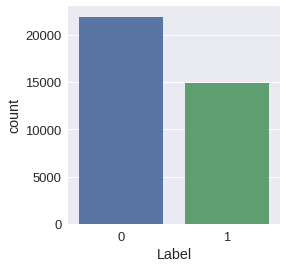

In [0]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

sns.factorplot(x="Label", data=train_data, kind="count")
plt.show();

In [0]:
from sklearn.model_selection import train_test_split

train_data,val_data,_,_=train_test_split(train_data, train_data['Label'] , test_size=0.1, random_state=42)

In [0]:
def build_model():
  
    base_model = DenseNet169(
                          weights='imagenet', 
                          input_shape=(224, 224, 3), 
                          pooling='max', 
                          classes=1000)
    
    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    x = Dense(1000, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    x = Dense(500, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    
    predictions = Dense(1,activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [0]:
model = build_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', 'mse'])

58548224/58541896 [==============================] - 1s 0us/step


In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [0]:
NUM_SAMPLES=train_data.shape[0]
VAL_SIZE=val_data.shape[0]
BATCH_SIZE=512
NUM_EPOCHS = 30

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    zoom_range=0.2,
    rotation_range=5,
    horizontal_flip=True
)

In [0]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_data, 
    directory  = DATASET_DIR, 
    x_col = "Path", 
    y_col = "Label", 
    target_size=(224, 224),
    color_mode='rgb', 
    class_mode='other', 
    batch_size=32
)

Found 33127 images.


In [0]:
val_datagen = ImageDataGenerator(
    rescale=1. / 255
)

In [0]:
val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_data, 
    directory  = DATASET_DIR, 
    x_col = "Path", 
    y_col = "Label", 
    target_size=(224, 224),
    color_mode='rgb', 
    class_mode='other', 
    batch_size=32
)

Found 3681 images.


In [0]:
model.fit_generator(
    generator = train_generator, 
    steps_per_epoch = NUM_SAMPLES/BATCH_SIZE,
    epochs=10,
    verbose=1, 
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=7, 
            min_delta=0.0001
        ),
        TensorBoard(
            log_dir='Graph_complete', 
            histogram_freq=0, 
            write_graph=True, 
            write_images=True
        )
    ], 
    validation_data=val_generator, 
    validation_steps = VAL_SIZE/BATCH_SIZE,
    shuffle=True
)

Epoch 1/10
65/64 [==============================] - 4856s 75s/step - loss: 155.5158 - acc: 0.4149 - mean_squared_error: 0.5851 - val_loss: 17.4823 - val_acc: 0.4297 - val_mean_squared_error: 0.5703
Epoch 2/10
57/64 [=========================>....] - ETA: 9:08 - loss: 12.6839 - acc: 0.4167 - mean_squared_error: 0.5833 